# Imports

In [1]:
from google.oauth2 import service_account
from google.cloud import monitoring_v3
import time
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import itertools
import datetime
import matplotlib.dates as mdates

# Data Import

In [2]:
credentials = service_account.Credentials.from_service_account_file(
    '../infrastructure/credentials.json')

project_id = '932771810925' # Our project ID

client = monitoring_v3.MetricServiceClient(credentials=credentials)
project_name = f"projects/{project_id}"
now = time.time()
seconds = int(now)
nanos = int((now - seconds) * 10 ** 9)
interval = monitoring_v3.TimeInterval(
    {
        "end_time": {"seconds": seconds, "nanos": nanos},
        # 3600 = Get the last hour of metrics
        "start_time": {"seconds": (seconds - (3600 * 1)), "nanos": nanos},
    }
)

In [3]:
results_cpu = client.list_time_series(
    request={
        "name": project_name,
        "filter": 'metric.type =  "compute.googleapis.com/instance/cpu/utilization"',
        "interval": interval,
        "view": monitoring_v3.ListTimeSeriesRequest.TimeSeriesView.FULL,
    }
)
results_io_read = client.list_time_series(
    request={
        "name": project_name,
        "filter": 'metric.type = "compute.googleapis.com/instance/disk/read_bytes_count"',
        "interval": interval,
        "view": monitoring_v3.ListTimeSeriesRequest.TimeSeriesView.FULL,
    }
)
results_io_write = client.list_time_series(
    request={
        "name": project_name,
        "filter": 'metric.type = "compute.googleapis.com/instance/disk/write_bytes_count"',
        "interval": interval,
        "view": monitoring_v3.ListTimeSeriesRequest.TimeSeriesView.FULL,
    }
)
results_iops_read = client.list_time_series(
    request={
        "name": project_name,
        "filter": 'metric.type = "compute.googleapis.com/instance/disk/read_ops_count"',
        "interval": interval,
        "view": monitoring_v3.ListTimeSeriesRequest.TimeSeriesView.FULL,
    }
)
results_iops_write = client.list_time_series(
    request={
        "name": project_name,
        "filter": 'metric.type = "compute.googleapis.com/instance/disk/write_ops_count"',
        "interval": interval,
        "view": monitoring_v3.ListTimeSeriesRequest.TimeSeriesView.FULL,
    }
)

df = pd.DataFrame()
set_timestamp_column = True
first_len = 0
for ts_cpu, ts_io_read, ts_io_write, ts_iops_read, ts_iops_write in zip(results_cpu, results_io_read, results_io_write, results_iops_read, results_iops_write):
    # print(ts)
    label = ts_cpu.metric.labels["instance_name"]
    print(label + ": " + str(len(ts_cpu.points)))
    if set_timestamp_column:
        df['timestamp'] = pd.to_datetime([p.interval.start_time for p in ts_cpu.points])
        first_len=len(ts_cpu.points)
        set_timestamp_column = False
    # print(ts.points[0])
    # When deploying the vm they might take different amount of time leading to some values beeing available a minute early this leading to different length
    # We can trim off the last values as they are orderer from most recent to last
    df['cpu_util_' + label] = [p.value.double_value for p in ts_cpu.points[:first_len]]
    df['io_read_' + label] = [p.value.int64_value for p in ts_io_read.points[:first_len]]
    df['io_write_' + label] = [p.value.int64_value for p in ts_io_write.points[:first_len]]
    df['iops_read_' + label] = [p.value.int64_value for p in ts_iops_read.points[:first_len]]
    df['iops_write_' + label] = [p.value.int64_value for p in ts_iops_write.points[:first_len]]

df.set_index('timestamp', inplace=True)
df.index = pd.to_datetime(df.index)
columns = df.columns
df.to_csv("export.csv")
df.head()



syncmesh-instance-2: 57
syncmesh-instance-3: 57
syncmesh-instance-1: 57
test-orchestrator: 57
client-instance: 57
central-server-instance: 57


,cpu_util_syncmesh-instance-2,io_read_syncmesh-instance-2,io_write_syncmesh-instance-2,iops_read_syncmesh-instance-2,iops_write_syncmesh-instance-2,cpu_util_syncmesh-instance-3,io_read_syncmesh-instance-3,io_write_syncmesh-instance-3,iops_read_syncmesh-instance-3,iops_write_syncmesh-instance-3,...,cpu_util_client-instance,io_read_client-instance,io_write_client-instance,iops_read_client-instance,iops_write_client-instance,cpu_util_central-server-instance,io_read_central-server-instance,io_write_central-server-instance,iops_read_central-server-instance,iops_write_central-server-instance
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-07-20 00:37:00+00:00,0.102379,463334,935951,21,117,0.788421,928911055,318700,16995,57,...,0.031314,487317,301794,22,56,0.038864,0,592925,0,46
2021-07-20 00:36:00+00:00,0.101479,829315,1015953,45,140,0.832472,933693855,232339,17258,44,...,0.007118,0,121062,0,25,0.037984,1340,1566335,0,115
2021-07-20 00:35:00+00:00,0.102089,471267,907107,30,114,0.871402,937739224,215211,16902,44,...,0.007442,0,13583,0,2,0.085606,15044,7463870,3,416
2021-07-20 00:34:00+00:00,0.100402,597344,893662,37,104,0.768374,919304178,366244,16604,65,...,0.005537,0,0,0,0,0.056260,0,1629997,0,104
2021-07-20 00:33:00+00:00,0.131333,4177917,1361679,218,160,0.571791,893641441,384606,16346,74,...,0.005249,0,0,0,0,0.037291,0,522608,0,43


# Test

## CPU

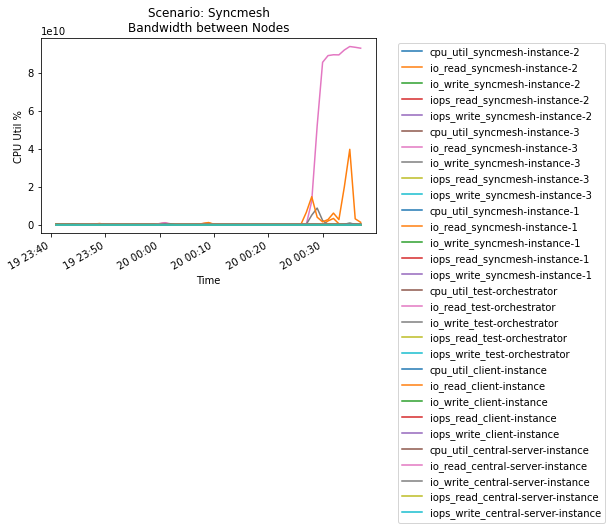

In [4]:
df = pd.read_csv("export.csv")
df.set_index('timestamp', inplace=True)
df.index = pd.to_datetime(df.index)

fig, ax = plt.subplots()

# ax.set_ylim(0,500)
for col in columns: 
    if(col.
    ax.plot(df.index, df[col]*100, label=col)
# set title and legend
ax.set_title('CPU')
ax.set_ylabel("CPU Util %")
ax.set_xlabel("Time")
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
fig.autofmt_xdate()

fig.savefig("out/cpu_util.png")
plt.show()

## IO

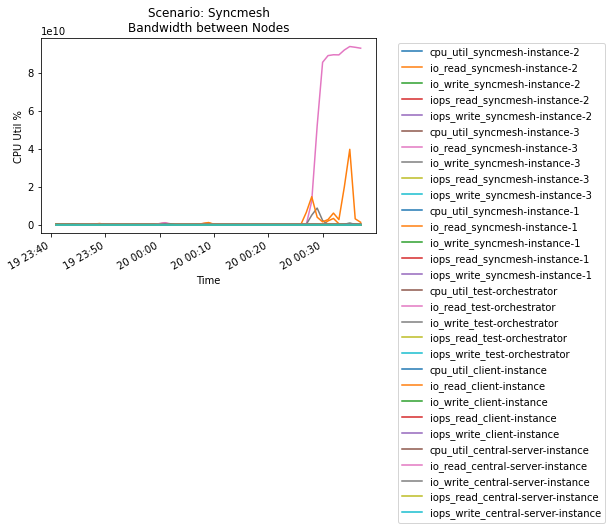

In [4]:
df = pd.read_csv("export.csv")
df.set_index('timestamp', inplace=True)
df.index = pd.to_datetime(df.index)

fig, ax = plt.subplots()

# ax.set_ylim(0,500)
for col in columns: 
    ax.plot(df.index, df[col]*100, label=col)
# set title and legend
ax.set_title('Scenario: Syncmesh\nBandwidth between Nodes')
ax.set_ylabel("CPU Util %")
ax.set_xlabel("Time")
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
fig.autofmt_xdate()

fig.savefig("out/cpu_util.png")
plt.show()

## IOPS

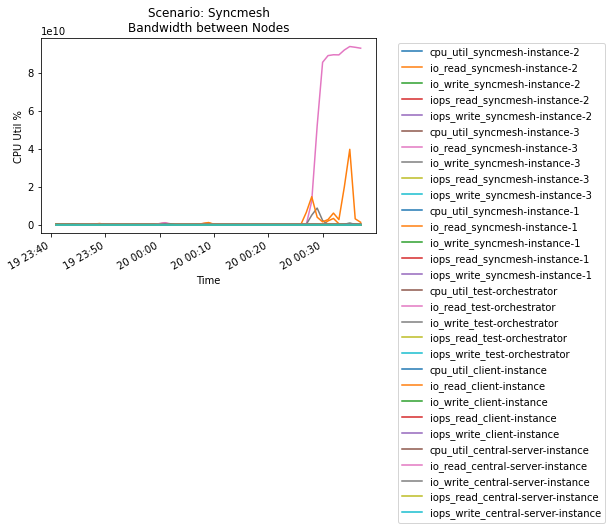

In [4]:
df = pd.read_csv("export.csv")
df.set_index('timestamp', inplace=True)
df.index = pd.to_datetime(df.index)

fig, ax = plt.subplots()

# ax.set_ylim(0,500)
for col in columns: 
    ax.plot(df.index, df[col]*100, label=col)
# set title and legend
ax.set_title('Scenario: Syncmesh\nBandwidth between Nodes')
ax.set_ylabel("CPU Util %")
ax.set_xlabel("Time")
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
fig.autofmt_xdate()

fig.savefig("out/cpu_util.png")
plt.show()